In [166]:
import pandas as pd
import matplotlib
import plotly
import tkinter
import os
import numpy as np
import seaborn
import plotly.express
import kaleido
import nbformat

In [167]:
save_TS_plots = False
save_violin_plots = False
save_quantile_plots = True
locatie = 'parkhaven'
#pd.options.plotting.backend = "plotly"
pd.options.plotting.backend = "matplotlib"

In [ ]:
with open('teams_path') as f:
    lines = f.readlines
teams_path[0] + '/'

In [168]:

df = pd.read_table(teams_path + 'telecontrol/'+locatie+'.csv',delimiter = '\t')
numeric_cols = df.columns[2:]
df[numeric_cols] = df[numeric_cols].stack().str.replace(',','.').unstack()
df.head()
df.drop(df.tail(5).index,inplace = True)
df['datetime'] = pd.to_datetime(df['Datum'] + ' ' + df['Tijd (Europe/Amsterdam)'])
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

#df['OW000-008/WNS7670 - gemeten waarde [mS/cm]'] = pd.to_numeric(df['OW000-008/WNS7670 - gemeten waarde [mS/cm]'],errors='coerce')
df.head()
df = df.set_index('Datum')
df[numeric_cols] = np.where(df[numeric_cols]>=100 , np.nan, df[numeric_cols])
df['maand'] = df['datetime'].dt.strftime('%b')


In [169]:
%%capture
isExist = os.path.exists(teams_path+'plots/' + locatie)
if not isExist:
    os.makedirs(teams_path+'plots/' + locatie)


if save_TS_plots:
    root = tkinter.Tk()
    my_dpi = root.winfo_fpixels('1i')

    subsets = (['2015-01-01', '2015-31-12'], ['2016-01-01', '2016-31-12'], ['2017-01-01', '2017-31-12'], ['2018-01-01', '2018-31-12'],
               ['2019-01-01', '2019-31-12'], ['2020-01-01', '2020-31-12'], ['2021-01-01','2021-31-12'], ['2022-01-01', '2022-31-12'],
               ['2015-01-01', '2022-31-12']
               )

    for subset in subsets:
        #subset = ['2015-01-01','2015-31-12']
        plot1 = df.loc[subset[0]:subset[1]].plot(
            'datetime', df.columns[2], figsize=(1920/my_dpi, 1080/my_dpi))
        axes = plot1.xaxis
        axes.set_major_locator(matplotlib.dates.MonthLocator(interval=1))
        axes.get_major_ticks()[-1].label1.set_visible(False)
        plot1.set_xlabel('Datum')
        plot1.set_ylabel('EGV')
        plot1.set_title(
            'Van ' + subset[0] + ' t/m ' + subset[1] + '\n Locatie: ' + locatie)
        plot = plot1.figure
        plot_int = plotly.tools.mpl_to_plotly(plot)
        plot_int.write_html(teams_path+"plots/" + locatie +
                            '/' + locatie + subset[0] + '_' + subset[1] + ".html")
        plot_int.write_image(teams_path+"plots/" +
                             locatie + '/' + locatie + subset[0] + '_' + subset[1] + ".png")


if save_violin_plots:
    plot2 = plotly.express.violin(df, x='maand', y=numeric_cols[1], points=False, 
    title='EGV verdeling per maand op locatie: ' + locatie, labels={numeric_cols[1]: 'EGV (mS/cm)'},
    category_orders={"maand": ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]})
    #plot2.set_ylabel('EGV (mS/cm')
    # plot2.show()
    #plot2 = plot2.figure
    #plot_int = plotly.tools.mpl_to_plotly(plot2)
    plot2.write_html(teams_path+"plots/" + locatie +
                     '/' + locatie + "_violin.html")
    plot2.write_image(teams_path +
                         "plots/" + locatie + '/' + locatie + "_violin.png")


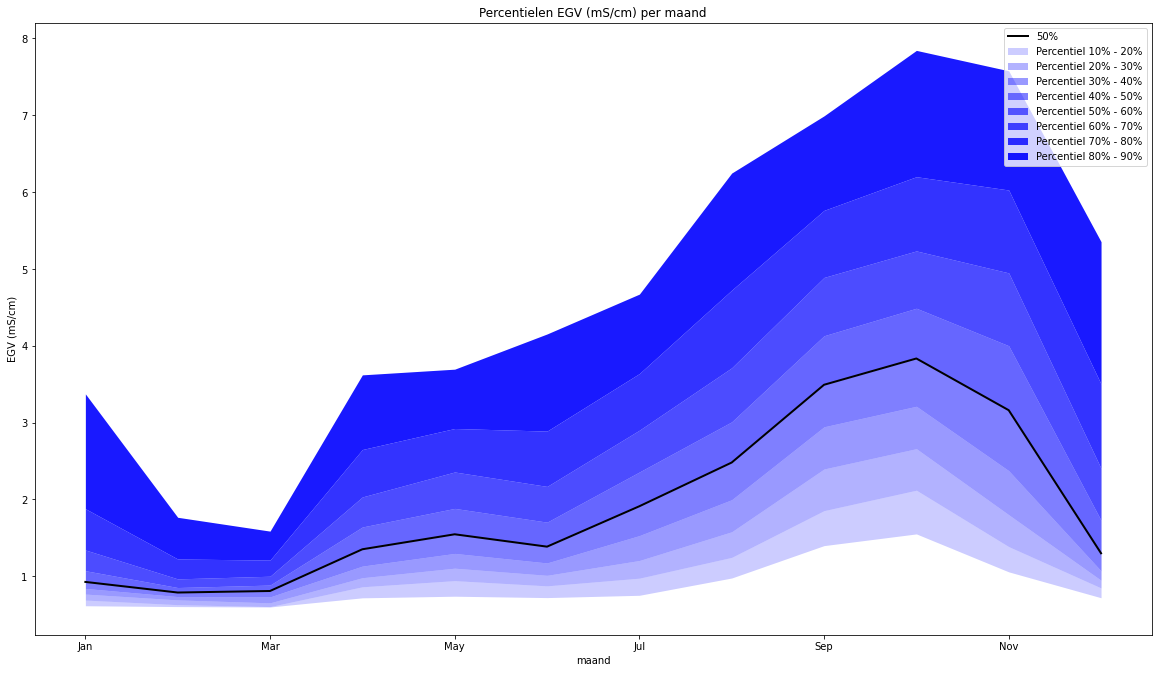

In [170]:
if save_quantile_plots:
    category_orders={"maand": ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]}
    df1 = df[['maand',numeric_cols[1]]]
    df2 = df1.groupby('maand').quantile([0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90])
    df3 = df2[df2.columns[0]].unstack().reindex(category_orders['maand'])
    df3[0.5].plot(color = 'black',linewidth = 2,figsize=(1920/my_dpi, 1080/my_dpi),
    title = 'Percentielen EGV (mS/cm) per maand', xlabel = 'maand', ylabel = 'EGV (mS/cm)',label = '50%')
    for i,col in enumerate(df3.columns):
        if i < len(df3.columns)-1:
            #alpha = (1-abs(col-0.5))
            alpha = col+0.1
            matplotlib.pyplot.fill_between(category_orders['maand'],df3[df3.columns[i]],df3[df3.columns[i+1]],alpha = alpha,color = 'blue',linewidth = 0,
                label = f'Percentiel {df3.columns[i]*100:g}% - {df3.columns[i+1]*100:g}%')
    matplotlib.pyplot.legend()
    matplotlib.pyplot.savefig(teams_path +
                            "plots/" + locatie + '/' + locatie + "_percentielen.png")
